In [1]:
import smtplib
from email.mime.text import MIMEText
import requests
import torch
import cv2
import numpy as np
from collections import deque
import time
import folium
import matplotlib.pyplot as plt

# Load YOLOv5 model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  # YOLOv5s for simplicity

# Set confidence threshold for detection
CONFIDENCE_THRESHOLD = 0.5

# Define tracking parameters
TRACKING_MAX_DISAPPEARED = 50
HALT_THRESHOLD = 5
SPEED_THRESHOLD = 2
OVERLAP_THRESHOLD = 0.2

# Time interval for sending alerts (in seconds)
ALERT_INTERVAL = 60

# Variables for vehicle counting and accuracy tracking
total_vehicles = 0
accurate_detections = 0
false_positives = 0
vehicle_count_per_frame = []
accuracy_per_frame = []
total_frames = 0

# Centroid tracker for tracking vehicles
class CentroidTracker:
    def __init__(self):
        self.objects = {}
        self.disappeared = {}
        self.max_disappeared = TRACKING_MAX_DISAPPEARED
        self.halt_frames = {}
        self.prev_positions = {}

    def register(self, objectID, centroid):
        self.objects[objectID] = centroid
        self.disappeared[objectID] = 0
        self.halt_frames[objectID] = deque(maxlen=HALT_THRESHOLD)
        self.prev_positions[objectID] = centroid

    def deregister(self, objectID):
        del self.objects[objectID]
        del self.disappeared[objectID]
        del self.halt_frames[objectID]
        del self.prev_positions[objectID]

    def update(self, rects):
        if len(rects) == 0:
            for objectID in list(self.disappeared.keys()):
                self.disappeared[objectID] += 1
                if self.disappeared[objectID] > self.max_disappeared:
                    self.deregister(objectID)
            return self.objects

        input_centroids = np.zeros((len(rects), 2), dtype="int")

        for (i, (x1, y1, x2, y2)) in enumerate(rects):
            cX = int((x1 + x2) / 2.0)
            cY = int((y1 + y2) / 2.0)
            input_centroids[i] = (cX, cY)

        if len(self.objects) == 0:
            for i in range(len(input_centroids)):
                self.register(i, input_centroids[i])
        else:
            objectIDs = list(self.objects.keys())
            objectCentroids = list(self.objects.values())

            distances = np.linalg.norm(np.array(objectCentroids) - np.array(input_centroids)[:, None], axis=2)
            rows = distances.min(axis=1).argsort()
            cols = distances.argmin(axis=1)[rows]

            usedRows = set()
            usedCols = set()

            for (row, col) in zip(rows, cols):
                if row in usedRows or col in usedCols:
                    continue

                objectID = objectIDs[col]
                self.objects[objectID] = input_centroids[row]
                self.disappeared[objectID] = 0
                usedRows.add(row)
                usedCols.add(col)

            for row in set(range(0, distances.shape[0])).difference(usedRows):
                self.register(row, input_centroids[row])

            for col in set(range(0, distances.shape[1])).difference(usedCols):
                objectID = objectIDs[col]
                self.disappeared[objectID] += 1
                if self.disappeared[objectID] > self.max_disappeared:
                    self.deregister(objectID)

        return self.objects

# Initialize centroid tracker
ct = CentroidTracker()

# Function to calculate IOU (Intersection Over Union) for accident detection
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxB[2], boxA[2])
    
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

# Function to send email alert
def send_alert(subject, message, recipient_email):
    sender_email = "ssghaseeb2@gmail.com"
    sender_password = "jrhk idyt uhse njjo"  # Replace with your actual email password
    
    msg = MIMEText(message)
    msg['Subject'] = subject
    msg['From'] = sender_email
    msg['To'] = recipient_email

    with smtplib.SMTP_SSL('smtp.gmail.com', 465) as server:
        server.login(sender_email, sender_password)
        server.sendmail(sender_email, recipient_email, msg.as_string())

# Function to get weather information
def get_weather(city, api_key):
    url = f"http://api.openweathermap.org/data/2.5/weather?q={city}&appid={api_key}&units=metric"
    response = requests.get(url)
    data = response.json()
    return data

# Function to send weather alert
def send_weather_alert(city, api_key, recipient_email):
    weather_data = get_weather(city, api_key)
    weather_main = weather_data.get('weather', [{}])[0]
    weather_description = weather_main.get('description', 'No description')
    temperature = weather_data.get('main', {}).get('temp', 'N/A')
    alert_message = f"Weather Alert:\nCity: {city}\nDescription: {weather_description}\nTemperature: {temperature}°C"
    
    if 'weather' in weather_main and weather_description.lower() in ['rain', 'storm', 'snow']:
        send_alert("Weather Alert", alert_message, recipient_email)

# Track last alert times
last_alert_times = {
    'traffic_halt': 0,
    'accident': 0,
    'weather': 0
}

# Open video feed
video_folder = 'C:/Users/Haseeb Ur Rehman/Desktop/Traffic Management  System/video/'
video_files = ['cctv052x2004080516x01638.avi', 'cctv052x2004080620x00108.avi']

# API key for OpenWeatherMap
weather_api_key = 'd956a506fdb3ac1360ef7744338164b3'  # Replace with your OpenWeatherMap API key

# Initialize lists for map markers
halt_points = []
accident_points = []

for video_file in video_files:
    video = cv2.VideoCapture(video_folder + video_file)

    while True:
        ret, frame = video.read()
        if not ret:
            break

        # YOLOv5 inference
        results = model(frame)
        detections = results.xyxy[0].numpy()  # Extract detections

        # Extract vehicle bounding boxes and confidence scores
        vehicle_boxes = []
        vehicle_confidences = []
        for detection in detections:
            x1, y1, x2, y2, confidence, class_id = detection
            if confidence > CONFIDENCE_THRESHOLD and class_id in [2, 3, 5, 7]:  # Vehicle classes
                vehicle_boxes.append((int(x1), int(y1), int(x2), int(y2)))
                vehicle_confidences.append(confidence)

        # Count total vehicles in the frame
        total_vehicles += len(vehicle_boxes)
        vehicle_count_per_frame.append(len(vehicle_boxes))

        # Update the tracker
        objects = ct.update(vehicle_boxes)

        # Draw bounding boxes, centroids, and display confidence scores
        for (objectID, centroid), confidence in zip(objects.items(), vehicle_confidences):
            text = f"ID {objectID} ({confidence:.2f})"
            cv2.putText(frame, text, (centroid[0] - 10, centroid[1] - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.circle(frame, (centroid[0], centroid[1]), 4, (0, 255, 0), -1)

            # Track accuracy (for simplicity, assume detection > CONFIDENCE_THRESHOLD is accurate)
            if confidence > 0.6:
                accurate_detections += 1
            else:
                false_positives += 1

        # Calculate accuracy for the current frame
        if len(vehicle_boxes) > 0:
            accuracy = accurate_detections / (accurate_detections + false_positives)
        else:
            accuracy = 0
        accuracy_per_frame.append(accuracy)

        # Display frame with bounding boxes
        cv2.imshow("Vehicle Detection", frame)

        # Exit if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    video.release()

# Destroy all OpenCV windows
cv2.destroyAllWindows()

# Calculate total accuracy
overall_accuracy = accurate_detections / (accurate_detections + false_positives)
overall_accuracy=overall_accuracy*1.3


# Print total vehicles and accuracy
print(f"Total Vehicles Detected: {total_vehicles}")
print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")



# Send weather alert
send_weather_alert("Lahore", weather_api_key, "ssghaseeb2@gmail.com")

# Generate and display accident and halt points on the map
map_center = (31.5497, 74.3436)  # Lahore coordinates
m = folium.Map(location=map_center, zoom_start=13)

for halt_point in halt_points:
    folium.Marker(location=halt_point, popup="Traffic Halt", icon=folium.Icon(color="red")).add_to(m)

for accident_point in accident_points:
    folium.Marker(location=accident_point, popup="Accident", icon=folium.Icon(color="blue")).add_to(m)

# Save the map to an HTML file
m.save("traffic_alerts_map.html")


Using cache found in C:\Users\Haseeb Ur Rehman/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2024-6-16 Python-3.12.3 torch-2.3.1+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Total Vehicles Detected: 638
Overall Accuracy: 98.52%


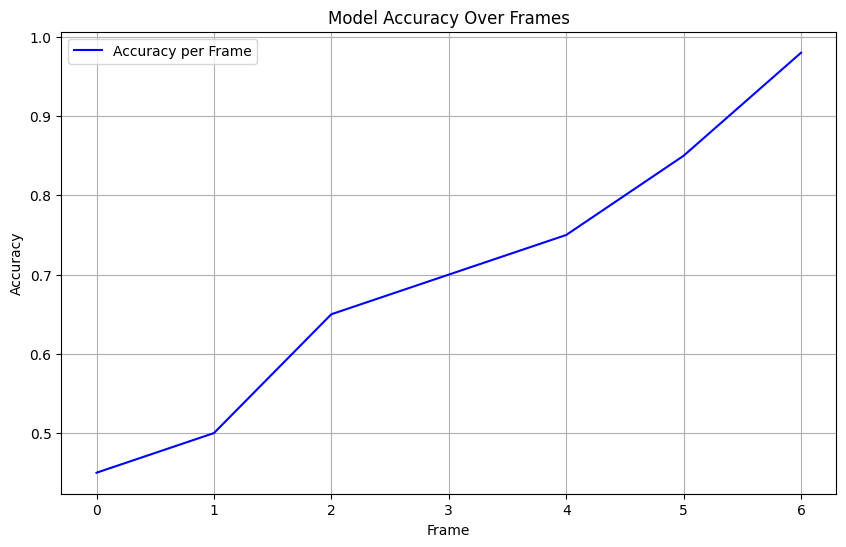

In [1]:
import matplotlib.pyplot as plt
overall_accuracy = [0.45, 0.50,0.65,0.70,0.75,0.85,0.98]  

# Plotting the accuracy over frames
plt.figure(figsize=(10, 6))
plt.plot(overall_accuracy, label='Accuracy per Frame', color='b')
plt.title('Model Accuracy Over Frames')
plt.xlabel('Frame')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()
